# Proyecto 6: Sistemas de recomendación

## Dataset

El dataset que vamos a usar en este proyecto es el del proyecto [MovieLens](http://grouplens.org/datasets/movielens/). Estos son relevados por el grupo de investigación GroupLens de la Universidad de Minnesota. Vamos a usar la versión 100K.

Está basado en un sistema de rating de 5 estrellas y texto libre para tags a partir del servicio de recomendaciones MovieLens. Contiene 100.000 ratings para 1.682 películas. Los datos fueron creados por 943 usuarios.

En el [Readme](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) del dataset se puede encontrar información adicional. A continuación vamos a describir cada uno de ellos.

### Ratings (u.data)

Cada línea representa el rating para una película para un usuario. Los ratings están basados en un sistema de 5 estrellas, con una salto de 0.5 estrellas. Los timestamps están expresados en segundos desde la medianoche de 01/1970 (UTC). El formato es:

`user id | item id | rating | timestamp`

### Usuarios (u.users)

Cada línea del archivo representa un usuario. Se incluye información demográfica. El formato es:

`user id | age | gender | occupation | zip code`

### Películas (u.item)

Cada línea corresponde a una película. Puede haber inconsistencias en los nombres. El formato es:

`movie id | movie title | release date | video release date | IMDb URL | generos`



Las columnas con los generos son binarias indicando la presencia o ausencia de cada uno en la película. Los géneros pueden ser:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* unknown

## Experimentación

Durante todo este proyecto vamos a utilizar la librería `surprise` para llevar a cabo las experimentaciones.

Como se mencionó en clase, las implementaciones en esta librería tiene algunas mejoras respecto de las estrategias convencionales como SVD. Esto se traduce en una mayor cantidad de parámetros para optimizar.

Vamos a levantar los datos. En primer lugar, definamos el formato para poder leer los datos.

**1) Utilizar** el `Reader` con el parámetro `line_format` igual a `'user item rating timestamp'` y `sep` como `'\t'`. Guardarlo en una variable `reader`.

In [1]:
from surprise import Dataset
from surprise import Reader

Utilizando este `reader` cargar los datos:

In [2]:
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file('./dataset/ml-100k/u.data', reader=reader)
#https://surprise.readthedocs.io/en/v1.0.0/getting_started.html?highlight=str

__2) Ejecutar una corrida inicial usando cross validation y el algoritmo SVD (5 folds). Imprimir los RMSE de testing.__

In [3]:
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import cross_validate

algo = KNNBasic()
cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9806  0.9786  0.9835  0.9723  0.9781  0.9786  0.0037  
MAE (testset)     0.7745  0.7730  0.7763  0.7677  0.7724  0.7728  0.0029  
Fit time          0.63    0.87    0.87    0.48    0.51    0.67    0.17    
Test time         4.13    5.19    4.73    3.59    3.03    4.13    0.77    


__3) Evaluar el RMSE (promedio de cross validation) de testing de acuerdo a la cantidad de factores en SVD.__

In [4]:
import numpy as np
rmse_test_means = []

factors = [5,100,200]
for factor in factors:
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'],  cv=3, verbose=False)
    rmse_test_means.append(np.mean(cv['test_rmse']))

__4) Graficar los promedios RMSE del conjunto de testing de acuerdo a la cantidad de factores en SVD.__

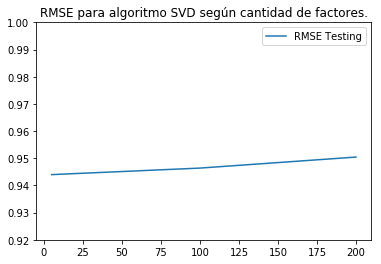

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(factors, rmse_test_means, label='RMSE Testing')
plt.ylim((0.92, 1.0))
plt.legend(loc="best")
plt.title("RMSE para algoritmo SVD según cantidad de factores.")
plt.show()

__5) Usando GridSearch, encontrar el mejor estimador usando SVD con 500 factores. Imprimir el mejor rmse. Utilizar `refit` para obtener obtener el mejor estimador ya ajustado como resultado.__

Utilizar el espacio de parámetros:
* n_epochs: [5, 10]
* lr_all: [0.002, 0.005]
* reg_all: [0.4, 0.6]


In [6]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

data = Dataset.load_builtin('ml-100k')

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [7]:
print(gs.best_params['rmse'])

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [8]:
print(gs.best_score['rmse'])

0.9640409820703435


__6) Obtener una predicción para el usuario 321 para la película Titanic.__

In [15]:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

In [19]:
uid = str(321)  # raw user id (as in the ratings file). They are **strings**!
iid = str(313)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 321        item: 313        r_ui = None   est = 3.98   {'was_impossible': False}
